In [1]:
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt

import palmettobug as pbug

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.


In [2]:
pbug.__version__

'0.2.11'

CHANGE The following directory to match an existing directory on your computer if you are testing this tutorial on your own machine!

In [3]:
my_computer_path =  "C:/Users/Default/Desktop"  ## CHANGE This DIRECTORY to match an existing directory on your computer if you are testing this tutorial on your own machine!

Set up a new directory and project
Here we:

1). Set up a fresh directory on our computer that we wll place the project

2). fetch the example data from PalmettoBUG into the project directory

3). load the directory into a pbug.ImageAnalysis object

In [4]:
# In this case, the data is from the MIBIsualization package (https://github.com/angelolab/MIBIsualization, 
    # which is GPL-3 licensed, just like palmettobug, although a specific copyright line is not provided in repository and it is unclear if raw data, as I use here, can be copyrighted at all)
# specifically, the single tiff file in { sample_data --> ChorotSlide1 --> CohortSlide1_TIFF --> bg_none } was used
        # (also tested previously on the filtered image: sample_data --> ChorotSlide1 --> CohortSlide1_TIFF --> bg_au_050_ta_20 --> the 'filtered' TIFF)
project_directory = my_computer_path + "/MIBI_test"

In [5]:
resolutions = [1.0, 1.0]    ## in micrometers. The default ( [1.0,1.0], as shown here) may be inaccurate for MIBI data, as MIBIScope can have variable resolutions
                            ## currently, PalmettoBUG does not read the resolution from the tiff file itself, it depends on the user remembering what resolution the 
                            ## experiment was run with
ImageAnalysis = pbug.imc_entrypoint(project_directory, resolutions =  resolutions, from_mcds = False)

In [6]:
## Unfortunately, PalmettoBUG does not read metadata from MIBI TIFF files, and the information of what each antigen was is not present in the MIBIsualization packages in 
## an easily accessible form (it may be inside the tifffiles, but if so this requires a specialized parser to extract)
## Instead, PalmettoBUG -- for now -- will rely on users to remember the order & composition of their panel

display(ImageAnalysis.panel)

,channel,name,keep,segmentation
0,0,Channel0,0,0
1,1,Channel1,1,0
2,2,Channel2,1,0
3,3,Channel3,1,0
4,4,Channel4,1,0
5,5,Channel5,1,0
6,6,Channel6,0,0
7,7,Channel7,1,0
8,8,Channel8,1,1
9,9,Channel9,1,2


In [7]:
## A user would normally assign meaningful names to each channel, but since I don't know what they are I just use generic names:
## note that you can't leave this column as numbers ! Otherwise you get an error when writing the ome-tiff during conversion from /raw --> images/img
ImageAnalysis.panel['name'] = ['Channel0','Channel1','Channel2','Channel3','Channel4','Channel5','Channel6','Channel7','Channel8','Channel9']
ImageAnalysis.panel['keep'] = [0,1,1,1,1,1,0,1,1,1]   ## remove gold and tantalum columns
ImageAnalysis.panel['segmentation'] = [0,0,0,0,0,0,0,0,1,2]   ## from appearance of the channels

In [8]:
display(ImageAnalysis.panel)

,channel,name,keep,segmentation
0,0,Channel0,0,0
1,1,Channel1,1,0
2,2,Channel2,1,0
3,3,Channel3,1,0
4,4,Channel4,1,0
5,5,Channel5,1,0
6,6,Channel6,0,0
7,7,Channel7,1,0
8,8,Channel8,1,1
9,9,Channel9,1,2


In [9]:
## We should be able to now proceed with assigning segmentation channels, segmenting, measuring, etc. as usual
## e.g. here we do the conversion from raw --> imgages/img folder with hot-pixel-filtering:
ImageAnalysis.panel_write()
ImageAnalysis.raw_to_img(hpf = 0.85) 

## all further steps should be effectively the same as for other image / MCD derived projects in PalmettoBUG,
# although will want more testing with a full MIBI project, eventually

In [10]:
## the hpf'd / converted file can be opened by tifffile & visualized as usual
## implies successful merger with PalmettoBUG standard workflows that start with MCDs 
image = tf.imread(my_computer_path + "/MIBI_test/images/img/Point1_RowNumber0_Depth_Profile0.tiff")
pbug.run_napari(image)

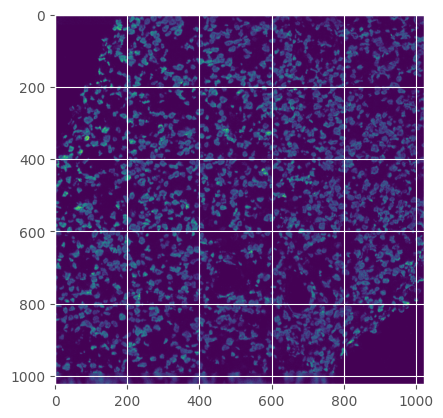

In [11]:
plt.imshow(image[6])   ### channel 8 (89Y) appears to be the DNA channel

In [13]:
kept = ImageAnalysis.panel[np.array(ImageAnalysis.panel['keep'] > 0)]
ImageAnalysis.instanseg_segmentation(re_do = True, mean_threshold = 0.25, channel_slice = np.array(kept['segmentation']))

Model fluorescence_nuclei_and_cells version 0.1.0 already downloaded in C:\Users\benca\miniforge3\envs\main\lib\site-packages\instanseg\utils\../bioimageio_models/, loading
Requesting default device: cpu


C:\Users\benca\miniforge3\envs\main\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|                                                                                           | 0/36 [00:00<?, ?it/s]C:\Users\benca\miniforge3\envs\main\lib\site-packages\torch\nn\modules\module.py:1750: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return forward_call(*args, **kwargs)
                                                                                                                       0.65s/it]

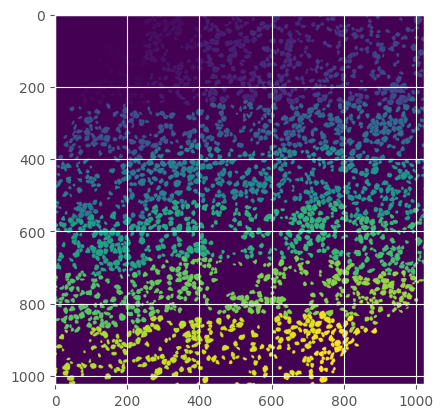

In [14]:
mask = tf.imread(my_computer_path + "/MIBI_test/masks/instanseg_masks/Point1_RowNumber0_Depth_Profile0.tiff")
plt.imshow(mask) 

In [15]:
pbug.run_napari(image, mask.astype('int'))